# Data Science Tech Case

by Guilherme Nascimento

## Conteúdo dos arquivos

**offer.json**

Contém os ids das ofertas e metadados de cada uma delas:
* id (string): id da oferta
* offer_type (string): o tipo da oferta (BOGO, discount, informational)
* min_value (int): valor mínimo para ativação da oferta
* duration (int): duração da oferta
* discount_value (int): valor do desconto
* channels (list of strings): canais de veiculação

**profile.json**

Contém atributos de cerca de 17k clientes:
* age (int): idade do cliente na criação da conta
* registeredon (int): data de criação da conta
* gender (string): gênero do cliente
* id (string): id do cliente
* credit_card_limit (float): limite do cartão registrado

**transactions.json**

Contém cerca de 300k eventos:

* event (str): descrição do evento (transação, oferta recebida, etc.)
* account_id (str): id do cliente
* time_since_test_start (int): tempo desde o começo do teste em dias (t=0)
* value (json): registra offer_id, desconto (reward) ou valor da transação

Este arquivo apresenta apenas o processamento de dados junto com EDA. Para modelagem acesse o arquivo ifood_datamodel.ipynb


In [1]:
#Imports e funções auxiliares

import pyspark
from pyspark.sql import SparkSession
from IPython.core.display import display
import matplotlib.pyplot as plt 
import pandas as pd
import seaborn as sns
from pyspark.sql.functions import array_contains
from pyspark.sql.functions import col, explode
pd.set_option('display.float_format', lambda x: '%.3f' % x)
from pyspark.sql.functions import sum as _sum, count as _count, mean as _mean, stddev as _stddev, when

#Algumas funções auxiliares
def city_size(city_pop):
    
    if city_pop<100000:
        return 'small'
    elif city_pop>=1e5 and city_pop < 1e6:
        return 'medium'
    else: 
        return 'large'

def bivariate_barplot(df_show, x_axis, y_axis, title,rotate_label=False, std=False, figsize=(10,6)):
    

    plt.figure(figsize=figsize)
    if rotate_label:
        plt.xticks(rotation=90)
    ax=None
    if std:
        ax= sns.barplot(x=x_axis, y=y_axis, data=df_show, estimator=np.mean, ci="sd")
    else:
        ax= sns.barplot(x=x_axis, y=y_axis, data=df_show)
    plt.title(title, fontsize=16, color='black', loc='center')

    for container in ax.containers:
        ax.bar_label(container, fmt='%.0f') 
        
def plot_transactions_by_age(transactions_df):
    # Agregações no PySpark
    count_df = transactions_df.groupBy("age").agg(_count("amount").alias("count"))
    sum_df = transactions_df.groupBy("age").agg(_sum("amount").alias("total_amount"))

    # Converter para Pandas
    count_pd = count_df.toPandas().sort_values("age")
    sum_pd = sum_df.toPandas().sort_values("age")

    # Criar subplots lado a lado
    fig, axes = plt.subplots(2, 1, figsize=(50, 20))

    # Gráfico de contagem
    sns.barplot(data=count_pd, x="age", y="count", ax=axes[0])
    axes[0].set_title("Contagem de transações por idade")
    axes[0].set_xlabel("Idade")
    axes[0].set_ylabel("Contagem")

    # Gráfico de soma
    sns.barplot(data=sum_pd, x="age", y="total_amount", ax=axes[1])
    axes[1].set_title("Total de amount por idade")
    axes[1].set_xlabel("Idade")
    axes[1].set_ylabel("Total Amount")

    plt.tight_layout()
    plt.show()
    
def plot_transactions_by_gender(transactions_df):
    count_df = transactions_df.groupBy("gender").agg(_count("amount").alias("count"))
    sum_df = transactions_df.groupBy("gender").agg(_sum("amount").alias("total_amount"))

    count_pd = count_df.toPandas()
    sum_pd = sum_df.toPandas()

    fig, axes = plt.subplots(1, 2, figsize=(20, 5))

    sns.barplot(data=count_pd, x="gender", y="count", ax=axes[0])
    axes[0].set_title("Contagem de transações por gênero")
    axes[0].set_xlabel("Gênero")
    axes[0].set_ylabel("Contagem")

    # Gráfico de soma
    sns.barplot(data=sum_pd, x="gender", y="total_amount", ax=axes[1])
    axes[1].set_title("Total de amount por gênero")
    axes[1].set_xlabel("Gênero")
    axes[1].set_ylabel("Total Amount")

    plt.tight_layout()
    plt.show()
    
def plot_transactions_by_account_age(transactions_df):
    # Agregações no PySpark
    count_df = transactions_df.groupBy("account_age").agg(_count("amount").alias("count"))
    sum_df = transactions_df.groupBy("account_age").agg(_sum("amount").alias("total_amount"))

    # Converter para Pandas e ordenar
    count_pd = count_df.toPandas().sort_values("account_age")
    sum_pd = sum_df.toPandas().sort_values("account_age")

    # Criar subplots lado a lado
    fig, axes = plt.subplots(1, 2, figsize=(25, 5))

    # Gráfico de contagem
    sns.barplot(data=count_pd, x="account_age", y="count", ax=axes[0])
    axes[0].set_title("Contagem de transações por Account Age")
    axes[0].set_xlabel("Account Age (anos)")
    axes[0].set_ylabel("Contagem")

    # Gráfico de soma
    sns.barplot(data=sum_pd, x="account_age", y="total_amount", ax=axes[1])
    axes[1].set_title("Total de amount por Account Age")
    axes[1].set_xlabel("Account Age (anos)")
    axes[1].set_ylabel("Total Amount")

    plt.tight_layout()
    plt.show()
    
def plot_offer_completed_count_by_column(df, group_col, figsize=(10,5)):
    # Agregação PySpark
    agg_df = df.groupBy(group_col).agg(_count("offer_id").alias("count"))
    # Converter para Pandas e ordenar para eixo x organizado
    pd_df = agg_df.toPandas().sort_values(group_col)
    
    # Plot
    plt.figure(figsize=figsize)
    sns.barplot(data=pd_df, x=group_col, y="count")
    plt.xlabel(group_col)
    plt.ylabel("count")
    plt.title(f"Offer Completed Count by {group_col.capitalize()}")
    plt.show()
    


## Leitura de Dados e primeiras análises

Nessa seção iremos analisar o tipo e a organização dos dados dos 3 datasets. O Objetivo aqui é fazermos um primeiro merge com com os dados de ofertas, clientes e histórico de transação para assim fazermos as devidas análises.

In [2]:
spark = SparkSession.builder.appName("iFoodOfferEstimation").config("spark.sql.autoBroadcastJoinThreshold", "-1").getOrCreate()


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/08/11 22:14:05 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
offers_df = spark.read.json("../data/processed/offers.json")
profile_df = spark.read.json("../data/processed/profile.json")
transactions_df = spark.read.json("../data/processed/transactions.json")

In [4]:
#Offers
pd_offers_df = offers_df.limit(10).toPandas()
pd_offers_df

,channels,discount_value,duration,id,min_value,offer_type
0,"[email, mobile, social]",10,7.000,ae264e3637204a6fb9bb56bc8210ddfd,10,bogo
1,"[web, email, mobile, social]",10,5.000,4d5c57ea9a6940dd891ad53e9dbe8da0,10,bogo
2,"[web, email, mobile]",0,4.000,3f207df678b143eea3cee63160fa8bed,0,informational
3,"[web, email, mobile]",5,7.000,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,bogo
4,"[web, email]",5,10.000,0b1e1539f2cc45b7b9fa7c272da2e1d7,20,discount
5,"[web, email, mobile, social]",3,7.000,2298d6c36e964ae4a3e7e9706d1fb8c2,7,discount
6,"[web, email, mobile, social]",2,10.000,fafdcd668e3743c1bb461111dcafc2a4,10,discount
7,"[email, mobile, social]",0,3.000,5a8bc65990b245e5a138643cd4eb9837,0,informational
8,"[web, email, mobile, social]",5,5.000,f19421c1d4aa40978ebb69ca19b0e20d,5,bogo
9,"[web, email, mobile]",2,7.000,2906b810c7d4411798c6938adc9daaa5,10,discount


In [5]:
#Checando quantidade de nulos
offers_df.select([_sum(col(c).isNull().cast("integer")).alias(c + "_nulls") for c in offers_df.columns]).show()

+--------------+--------------------+--------------+--------+---------------+----------------+
|channels_nulls|discount_value_nulls|duration_nulls|id_nulls|min_value_nulls|offer_type_nulls|
+--------------+--------------------+--------------+--------+---------------+----------------+
|             0|                   0|             0|       0|              0|               0|
+--------------+--------------------+--------------+--------+---------------+----------------+



In [6]:
#Profile
pd_profile_df = profile_df.limit(10).toPandas()
pd_profile_df

,age,credit_card_limit,gender,id,registered_on
0,118,NaN,None,68be06ca386d4c31939f3a4f0e3dd783,20170212
1,55,112000.000,F,0610b486422d4921ae7d2bf64640c50b,20170715
2,118,NaN,None,38fe809add3b4fcf9315a9694bb96ff5,20180712
3,75,100000.000,F,78afa995795e4d85b5d9ceeca43f5fef,20170509
4,118,NaN,None,a03223e636434f42ac4c3df47e8bac43,20170804
5,68,70000.000,M,e2127556f4f64592b11af22de27a7932,20180426
6,118,NaN,None,8ec6ce2a7e7949b1bf142def7d0e0586,20170925
7,118,NaN,None,68617ca6246f4fbc85e91a2a49552598,20171002
8,65,53000.000,M,389bc3fa690240e798340f5a15918d5c,20180209
9,118,NaN,None,8974fc5686fe429db53ddde067b88302,20161122


In [7]:
#Checando quantidade de nulos
profile_df.select([_sum(col(c).isNull().cast("integer")).alias(c + "_nulls") for c in profile_df.columns]).show()

+---------+-----------------------+------------+--------+-------------------+
|age_nulls|credit_card_limit_nulls|gender_nulls|id_nulls|registered_on_nulls|
+---------+-----------------------+------------+--------+-------------------+
|        0|                   2175|        2175|       0|                  0|
+---------+-----------------------+------------+--------+-------------------+



In [8]:
#transactions
pd_trans_df = transactions_df.limit(10).toPandas()
pd_trans_df

,account_id,event,time_since_test_start,value
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0.000,"(None, 9b98b8c7a33c4b65b9aebfe6a799e6d9, None,..."
1,a03223e636434f42ac4c3df47e8bac43,offer received,0.000,"(None, 0b1e1539f2cc45b7b9fa7c272da2e1d7, None,..."
2,e2127556f4f64592b11af22de27a7932,offer received,0.000,"(None, 2906b810c7d4411798c6938adc9daaa5, None,..."
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0.000,"(None, fafdcd668e3743c1bb461111dcafc2a4, None,..."
4,68617ca6246f4fbc85e91a2a49552598,offer received,0.000,"(None, 4d5c57ea9a6940dd891ad53e9dbe8da0, None,..."
5,389bc3fa690240e798340f5a15918d5c,offer received,0.000,"(None, f19421c1d4aa40978ebb69ca19b0e20d, None,..."
6,c4863c7985cf408faee930f111475da3,offer received,0.000,"(None, 2298d6c36e964ae4a3e7e9706d1fb8c2, None,..."
7,2eeac8d8feae4a8cad5a6af0499a211d,offer received,0.000,"(None, 3f207df678b143eea3cee63160fa8bed, None,..."
8,aa4862eba776480b8bb9c68455b8c2e1,offer received,0.000,"(None, 0b1e1539f2cc45b7b9fa7c272da2e1d7, None,..."
9,31dda685af34476cad5bc968bdb01c53,offer received,0.000,"(None, 0b1e1539f2cc45b7b9fa7c272da2e1d7, None,..."


In [9]:
#Checando quantidade de nulos
transactions_df.select([_sum(col(c).isNull().cast("integer")).alias(c + "_nulls") for c in transactions_df.columns]).show()

+----------------+-----------+---------------------------+-----------+
|account_id_nulls|event_nulls|time_since_test_start_nulls|value_nulls|
+----------------+-----------+---------------------------+-----------+
|               0|          0|                          0|          0|
+----------------+-----------+---------------------------+-----------+



Aqui tratamos os canais de oferta para one hot encoding

In [10]:
# Converting all offer channels in one-hot encoding

unique_channels = offers_df.select(explode(col("channels")).alias("channel")).distinct()
channel_list = [row["channel"] for row in unique_channels.collect()]

# Adiciona uma coluna binária para cada canal
for channel in channel_list:
    offers_df = offers_df.withColumn(
        f"offer_has_{channel}", array_contains(col("channels"), channel).cast("int")
    )
offers_df = offers_df.drop('channels')
offers_df.limit(5).toPandas()

,discount_value,duration,id,min_value,offer_type,offer_has_mobile,offer_has_email,offer_has_social,offer_has_web
0,10,7.000,ae264e3637204a6fb9bb56bc8210ddfd,10,bogo,1,1,1,0
1,10,5.000,4d5c57ea9a6940dd891ad53e9dbe8da0,10,bogo,1,1,1,1
2,0,4.000,3f207df678b143eea3cee63160fa8bed,0,informational,1,1,0,1
3,5,7.000,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,bogo,1,1,0,1
4,5,10.000,0b1e1539f2cc45b7b9fa7c272da2e1d7,20,discount,0,1,0,1


Aqui tratamos as colunas das transações existents. Nesse dataset as transações incluem as proprias compras como também as ofertas recebidas

In [11]:
# Lets put all all toghether

transactions_df = transactions_df.withColumn("amount", col("value.amount")) \
                    .withColumn("offer_id_from_struct", col("value.`offer id`")) \
                    .withColumn("offer_id", col("value.offer_id")) \
                    .withColumn("reward", col("value.reward"))

transactions_df = transactions_df.drop("value")
transactions_df.limit(5).toPandas()

,account_id,event,time_since_test_start,amount,offer_id_from_struct,offer_id,reward
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0.000,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,None,NaN
1,a03223e636434f42ac4c3df47e8bac43,offer received,0.000,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,None,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,0.000,NaN,2906b810c7d4411798c6938adc9daaa5,None,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0.000,NaN,fafdcd668e3743c1bb461111dcafc2a4,None,NaN
4,68617ca6246f4fbc85e91a2a49552598,offer received,0.000,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,None,NaN


Por fim juntamos todas as transações com os perfis existentes

In [12]:
#Put all together
df_final = transactions_df.join(profile_df, transactions_df.account_id == profile_df.id, "left")
df_final = df_final.drop('id')
df_final = df_final.join(offers_df, transactions_df.offer_id_from_struct == offers_df.id, "left")
df_final = df_final.drop('id').filter(col('age')!=118) #An outlier
#.join(offers_df, transactions_df.offer_id_from_struct == offers_df.id, "left")
df_final.limit(5).toPandas()

,account_id,event,time_since_test_start,amount,offer_id_from_struct,offer_id,reward,age,credit_card_limit,gender,registered_on,discount_value,duration,min_value,offer_type,offer_has_mobile,offer_has_email,offer_has_social,offer_has_web
0,0020ccbbb6d84e358d3414a3ff76cffd,transaction,1.750,16.270,None,None,NaN,24,60000.000,F,20161111,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN
1,0020ccbbb6d84e358d3414a3ff76cffd,transaction,9.250,11.650,None,None,NaN,24,60000.000,F,20161111,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN
2,0020ccbbb6d84e358d3414a3ff76cffd,offer completed,9.250,NaN,None,2298d6c36e964ae4a3e7e9706d1fb8c2,3.000,24,60000.000,F,20161111,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN
3,004c5799adbf42868b9cff0396190900,transaction,9.250,43.210,None,None,NaN,54,99000.000,M,20160331,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN
4,004c5799adbf42868b9cff0396190900,offer completed,9.250,NaN,None,fafdcd668e3743c1bb461111dcafc2a4,2.000,54,99000.000,M,20160331,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN


## Exploratory Data Analysis

Nessa seção vamos ver como os dados são distribuídos. Aqui iremos encontrar os seguintes plots:

* Distribuição e eventos por tipo (transação e oferta)
* Quantia e quantidade de transações por gênero
* Quantia e quantidade de transações por idade
* Quantia e quantidade de transações por tempo de cadastro do cliente
* Quantidade de ofertas aceitas/apenas vistas por idade, geênero e tempo de cadastro
* Distribuição de ofertas por tipo (bongo, discount e informational)

O intuito na geração desses dados é compreender como as ofertas são usadas pelas características de cada cliente a fim de criarmos um conjunto de dados limpo para a criação de um modelo predição de ofertas para cada tipo de cliente

## Tipo de transação (transação-compra) ou envio e concretização de ofertas

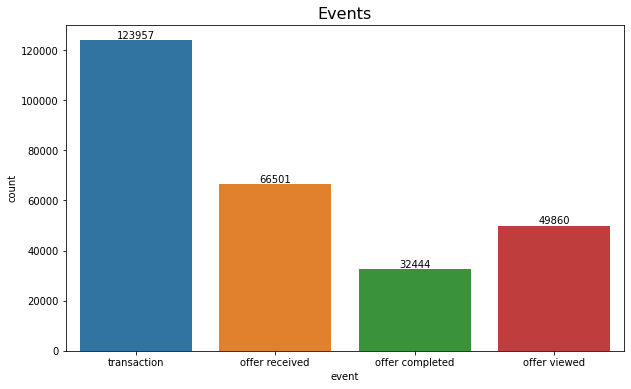

In [13]:
df_pandas = df_final.groupBy('event').count().toPandas()
bivariate_barplot(df_pandas, 'event', 'count', 'Events',rotate_label=False, std=False, figsize=(10,6))

Dando uma olhada nas ofertas concretizadas

In [14]:
df_final.filter(df_final["event"] == 'offer completed').select('event','amount','offer_id_from_struct','offer_id','reward').limit(5).toPandas()

,event,amount,offer_id_from_struct,offer_id,reward
0,offer completed,NaN,None,f19421c1d4aa40978ebb69ca19b0e20d,5.000
1,offer completed,NaN,None,fafdcd668e3743c1bb461111dcafc2a4,2.000
2,offer completed,NaN,None,2906b810c7d4411798c6938adc9daaa5,2.000
3,offer completed,NaN,None,2298d6c36e964ae4a3e7e9706d1fb8c2,3.000
4,offer completed,NaN,None,0b1e1539f2cc45b7b9fa7c272da2e1d7,5.000


In [15]:
#df_final.toPandas().to_parquet('ifood_transactions.parquet')

## Transações

Nessa seção vamos transformar os dados de transações para podermos usar como caracteristica de uso da plataforma para cada usuário.
Aqui criamos a idade da conta do usuário como feature

In [16]:
# Transactions -- Adding account age
from pyspark.sql.functions import col, to_date, datediff, current_date, floor

transactions = df_final.filter(col("event") == "transaction") \
                 .select("account_id", "amount", "age", "credit_card_limit", "gender", "registered_on")
transactions = transactions.withColumn("registered_on_date", to_date(col("registered_on"), "yyyyMMdd"))
transactions = transactions.withColumn("account_age", floor(datediff(current_date(), col("registered_on_date")) / 365))

transactions.limit(5).toPandas()

,account_id,amount,age,credit_card_limit,gender,registered_on,registered_on_date,account_age
0,0020c2b971eb4e9188eac86d93036a77,17.630,59,90000.000,F,20160304,2016-03-04,9
1,0020c2b971eb4e9188eac86d93036a77,32.000,59,90000.000,F,20160304,2016-03-04,9
2,0020c2b971eb4e9188eac86d93036a77,24.390,59,90000.000,F,20160304,2016-03-04,9
3,0020c2b971eb4e9188eac86d93036a77,24.310,59,90000.000,F,20160304,2016-03-04,9
4,0020c2b971eb4e9188eac86d93036a77,17.240,59,90000.000,F,20160304,2016-03-04,9


Vamos verificar o boxplot da quantidade gasta nas transações

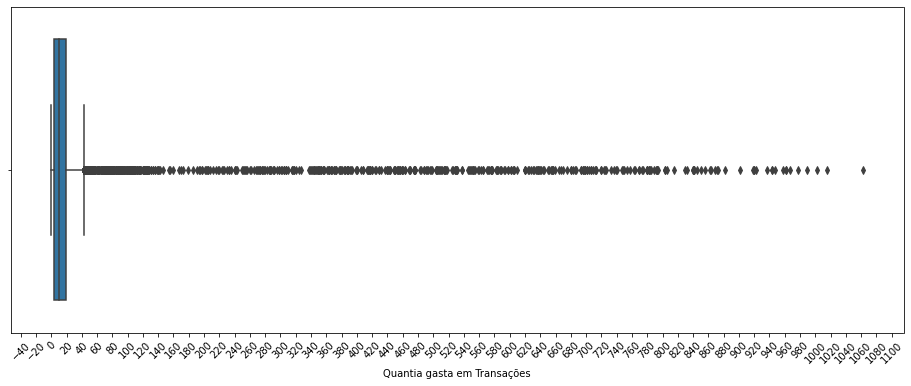

In [49]:
transactions_pd = transactions.toPandas()

plt.figure(figsize=(16, 6))
sns.boxplot(x=transactions_pd["amount"])
plt.locator_params(axis='x', nbins=80)
plt.xticks(rotation=45) 
plt.xlabel("Quantia gasta em Transações")
plt.show()

Também criamos algumas estatisticas das transações

In [17]:
stats_user_trans = transactions.groupBy("account_id") \
    .agg(
        _sum("amount").alias("amount_sum"),
        _count("amount").alias("amount_count"),
        _mean("amount").alias("amount_mean"),
        _stddev("amount").alias("amount_std")
    ) \
    .orderBy(col("amount_sum").desc())

stats_user_trans.limit(5).toPandas()

,account_id,amount_sum,amount_count,amount_mean,amount_std
0,3c8d541112a74af99e88abbd0692f00e,1608.690,8,201.086,331.702
1,f1d65ae63f174b8f80fa063adcaa63b7,1365.660,13,105.051,224.931
2,ae6f43089b674728a50b8727252d3305,1327.740,16,82.984,175.446
3,626df8678e2a4953b9098246418c9cfa,1321.420,13,101.648,259.844
4,73afdeca19e349b98f09e928644610f8,1319.970,10,131.997,225.086


Também verificar o boxplot do total gasto em todas as transações por cliente

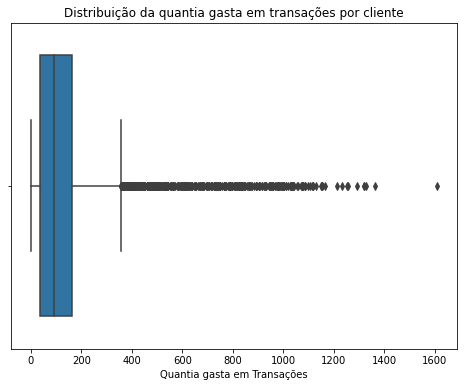

In [40]:
#Checando o gráfico boxplot para a quantia gasta em transações

stats_user_trans_pd = stats_user_trans.toPandas()

plt.figure(figsize=(8, 6))
sns.boxplot(x=stats_user_trans_pd["amount_sum"])
plt.title("Distribuição da quantia total gasta em transações por cliente")
plt.xlabel("Quantia total gasta em Transações")
plt.show()

Aqui geramo algumas distribuições de quantidade e total gasto por gênero, idade e tempo de conta

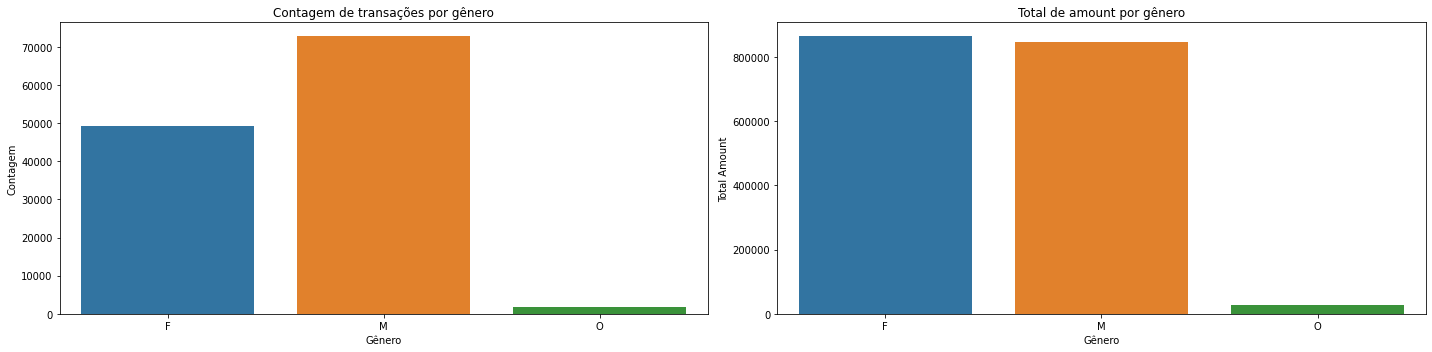

In [18]:
plot_transactions_by_gender(transactions)

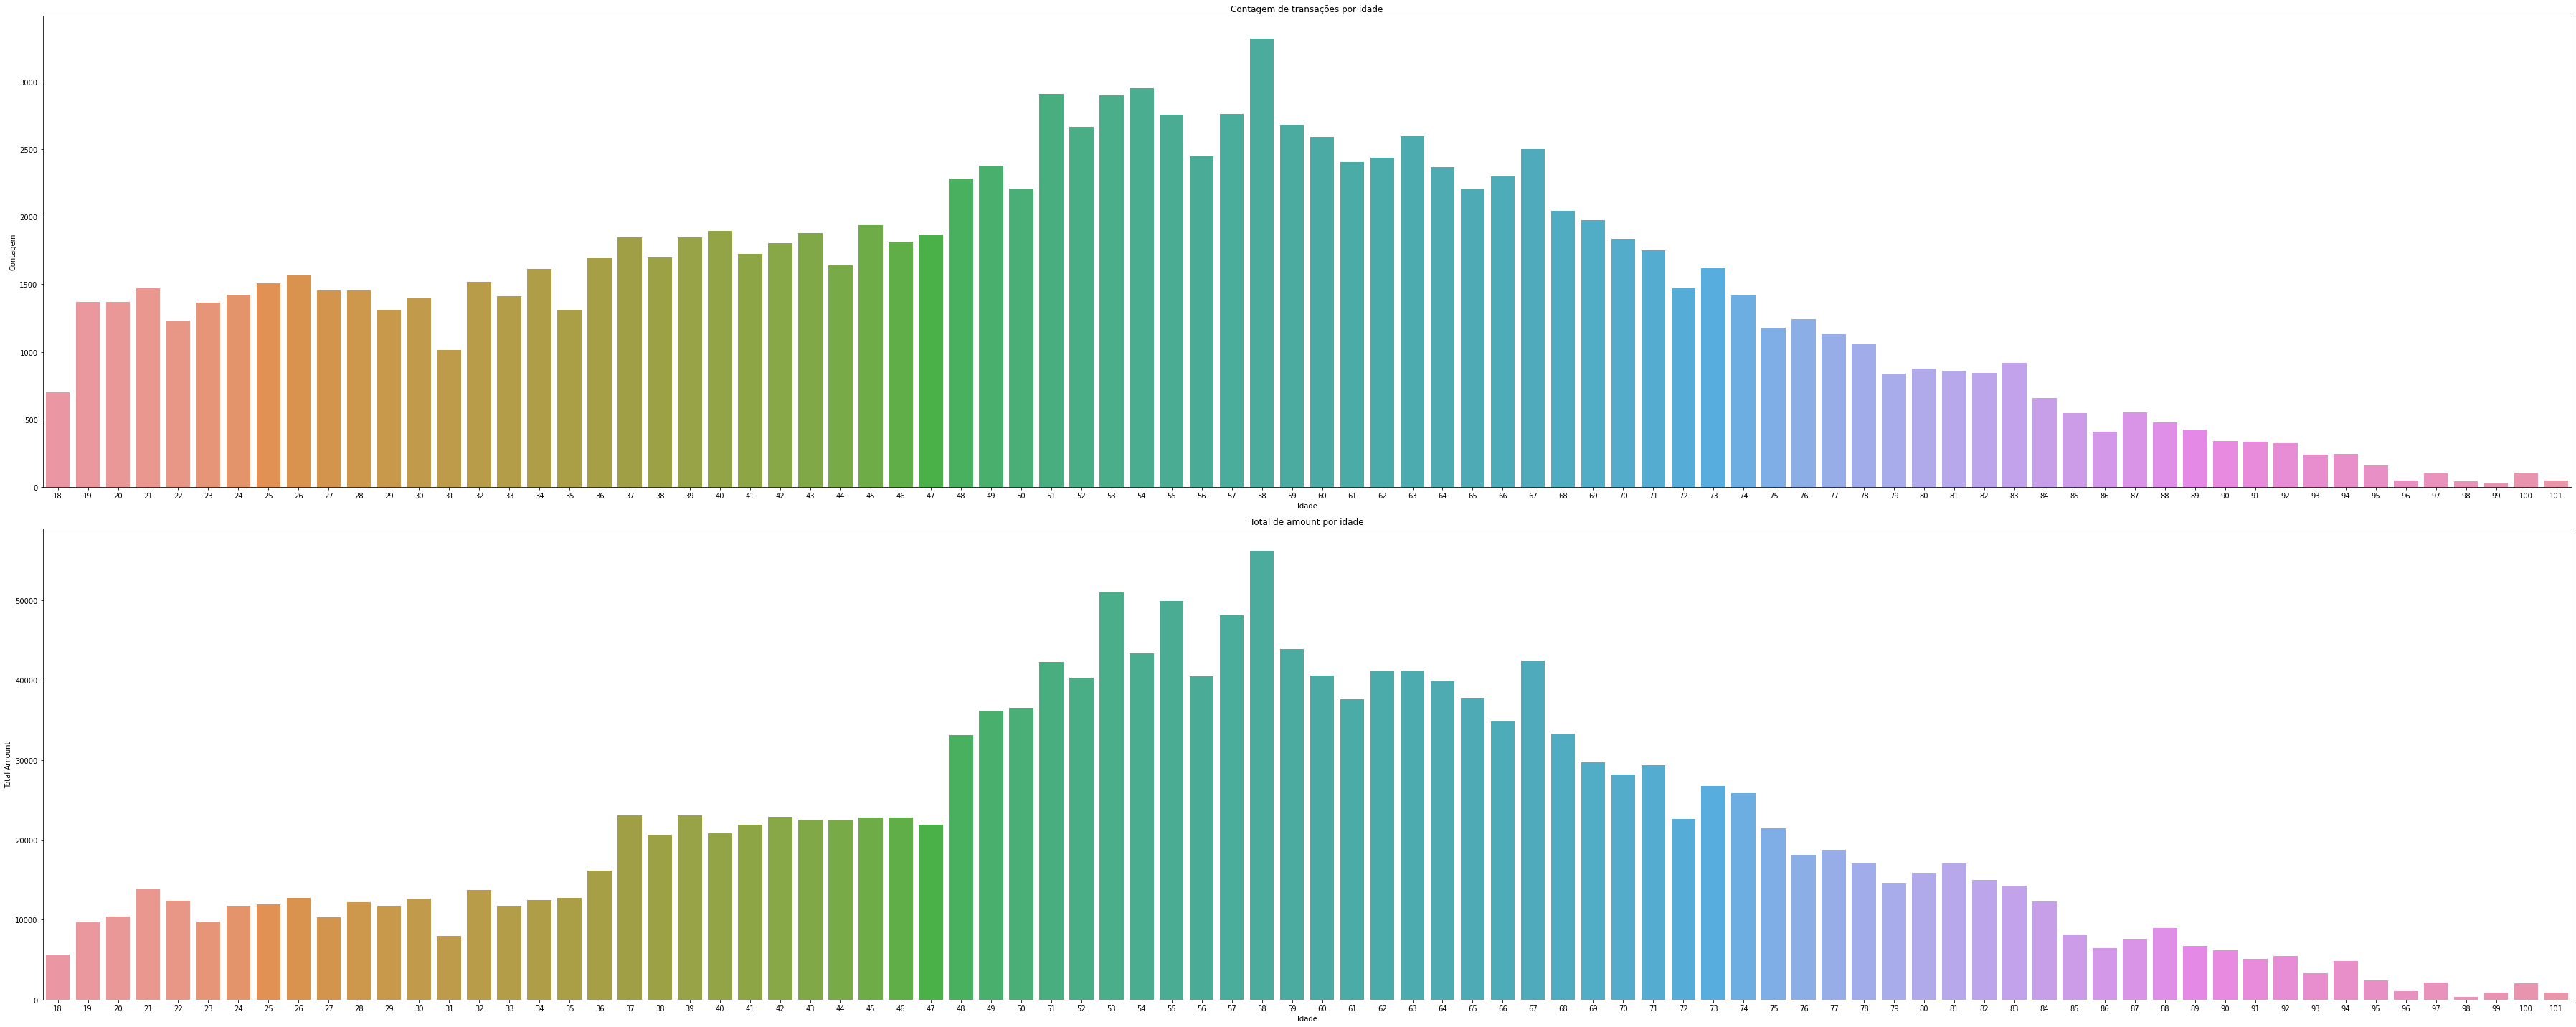

In [19]:
plot_transactions_by_age(transactions)

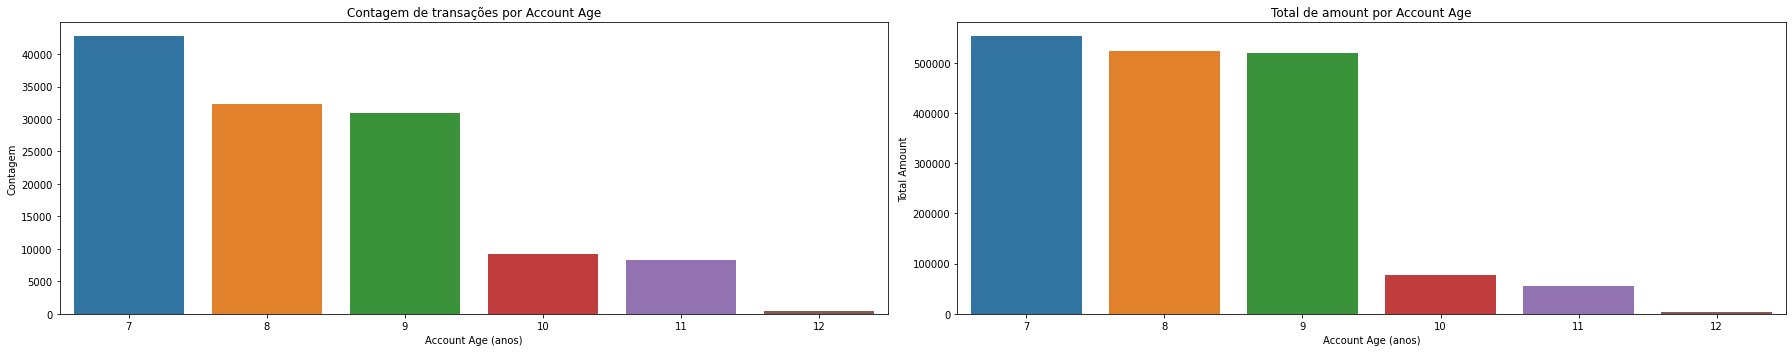

In [20]:
plot_transactions_by_account_age(transactions)

Juntando tudo nas informações de usuario

In [21]:
#Merging transactions with stats

transaction_data_merged = stats_user_trans.join(
    transactions.dropDuplicates(["account_id", "age", "gender", "registered_on"]),
    on="account_id",
    how="left"
).drop("amount", "credit_card_limit")

transaction_data_merged.limit(10).toPandas()

,account_id,amount_sum,amount_count,amount_mean,amount_std,age,gender,registered_on,registered_on_date,account_age
0,016871ea865d4338975026ae08d221d0,45.790,3,15.263,3.469,57,F,20180601,2018-06-01,7
1,01e09d713abe4a36a70a33fe4b40534e,86.260,4,21.565,6.082,60,F,20150824,2015-08-24,9
2,05ea8d8a95eb4b209a6e048878470df1,133.530,5,26.706,7.929,62,F,20151103,2015-11-03,9
3,08579355f46b49efa8412ddacc4ac832,134.990,6,22.498,8.106,60,F,20170807,2017-08-07,8
4,0bcecfedf7e448b08e5ed4c00f47217d,34.850,13,2.681,1.550,70,M,20131024,2013-10-24,11
5,0e18338db3524564870a52ee5cfe68a4,684.260,15,45.617,117.366,71,M,20160410,2016-04-10,9
6,1699f732aae74e71bcb7f1384cc88fde,122.950,6,20.492,4.753,69,M,20170405,2017-04-05,8
7,1f5904646e364d8e9e2a6bcc4566f5d6,21.190,3,7.063,3.288,56,M,20160831,2016-08-31,8
8,234f3b42e14245349935d57b937300dd,24.590,10,2.459,1.497,44,M,20171125,2017-11-25,7
9,25540a042d7d4aabbc464105e6489efb,112.580,4,28.145,6.790,71,F,20171130,2017-11-30,7


## Ofertas

Nessa seção separamos os dados de ofertas. Aqui separamos os tipos de ofertas oferecidas no dataset *offers.json* e separamos entre ofertas recebidas e ofertas completadas (concretizadas). 

Ainda há um tratamento para ofertasdo tipo *informational* sendo que essa foi transformada em oferta completada se ela foi vista, já que é o ultimo estado em que ela pode ocorrer.

In [22]:
#Now Lets check orders


offers = df_final.filter(col("event") != "transaction").select(
        "account_id", "offer_id_from_struct", "offer_id", "event", "age", "gender",
        "registered_on", "discount_value", "duration", "min_value", "offer_type",
        "offer_has_mobile", "offer_has_email", "offer_has_social", "offer_has_web"
    ).withColumn("account_age",floor(datediff(current_date(), to_date(col("registered_on"),"yyyyMMdd")) / 365))

offers.limit(5).toPandas()

,account_id,offer_id_from_struct,offer_id,event,age,gender,registered_on,discount_value,duration,min_value,offer_type,offer_has_mobile,offer_has_email,offer_has_social,offer_has_web,account_age
0,0020ccbbb6d84e358d3414a3ff76cffd,None,2298d6c36e964ae4a3e7e9706d1fb8c2,offer completed,24,F,20161111,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,8
1,0011e0d4e6b944f998e987f904e8c1e5,None,2298d6c36e964ae4a3e7e9706d1fb8c2,offer completed,40,O,20180109,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,7
2,0020ccbbb6d84e358d3414a3ff76cffd,2298d6c36e964ae4a3e7e9706d1fb8c2,None,offer received,24,F,20161111,3.000,7.000,7.000,discount,1.000,1.000,1.000,1.000,8
3,0020ccbbb6d84e358d3414a3ff76cffd,2298d6c36e964ae4a3e7e9706d1fb8c2,None,offer viewed,24,F,20161111,3.000,7.000,7.000,discount,1.000,1.000,1.000,1.000,8
4,0011e0d4e6b944f998e987f904e8c1e5,2298d6c36e964ae4a3e7e9706d1fb8c2,None,offer received,40,O,20180109,3.000,7.000,7.000,discount,1.000,1.000,1.000,1.000,7


Segmentando apenas as ofertas recebidas, podemos verificar a distribuição em alguns tipos de veículos digitais como app, email, mídias sociais e web

In [23]:
from pyspark.sql.functions import sum as _sum

offers_received = offers.filter(col("event") == "offer received")
offer_environment = pd.DataFrame([
    {'Oferta Mobile':offers_received.agg(_sum("offer_has_mobile").alias("qtd")).collect()[0]['qtd'],
     'Oferta Email':offers_received.agg(_sum("offer_has_email").alias("qtd")).collect()[0]['qtd'],
     'Oferta Social Media':offers_received.agg(_sum("offer_has_social").alias("qtd")).collect()[0]['qtd'],
     'Oferta Web':offers_received.agg(_sum("offer_has_web").alias("qtd")).collect()[0]['qtd']
    }]).T.rename(columns={0: 'Quantidade'})

<AxesSubplot:>

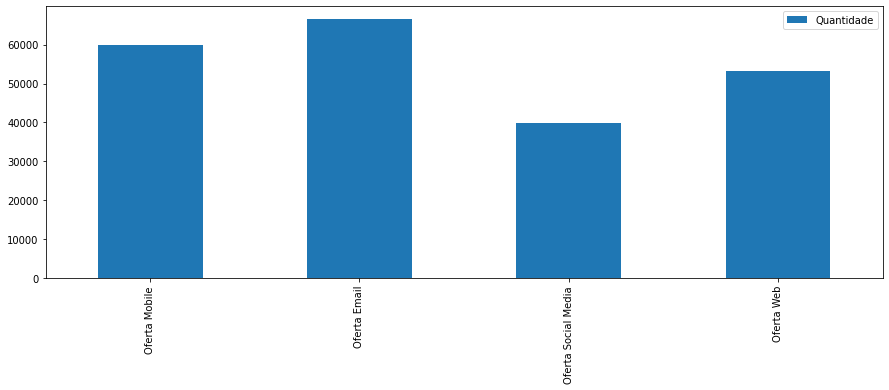

In [24]:
offer_environment.plot(kind='bar',figsize=(15,5))

Vamos transformar a informação de "offer viewed" para offer completed

In [25]:
offers = offers.withColumn(
    "event",
    when(
        (col("event") == "offer viewed") & (col("offer_type") == "informational"),
        "offer completed"
    ).otherwise(col("event"))
)

# Atualizar 'offer_id' com 'offer_id_from_struct' quando event='offer completed' e offer_type='informational'
offers = offers.withColumn(
    "offer_id",
    when(
        (col("event") == "offer completed") & (col("offer_type") == "informational"),
        col("offer_id_from_struct")
    ).otherwise(col("offer_id"))
)

offers.limit(5).toPandas()

,account_id,offer_id_from_struct,offer_id,event,age,gender,registered_on,discount_value,duration,min_value,offer_type,offer_has_mobile,offer_has_email,offer_has_social,offer_has_web,account_age
0,0020ccbbb6d84e358d3414a3ff76cffd,None,2298d6c36e964ae4a3e7e9706d1fb8c2,offer completed,24,F,20161111,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,8
1,0020ccbbb6d84e358d3414a3ff76cffd,None,f19421c1d4aa40978ebb69ca19b0e20d,offer completed,24,F,20161111,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,8
2,0020ccbbb6d84e358d3414a3ff76cffd,None,9b98b8c7a33c4b65b9aebfe6a799e6d9,offer completed,24,F,20161111,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,8
3,004b041fbfe44859945daa2c7f79ee64,None,f19421c1d4aa40978ebb69ca19b0e20d,offer completed,55,F,20180508,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,7
4,004b041fbfe44859945daa2c7f79ee64,None,fafdcd668e3743c1bb461111dcafc2a4,offer completed,55,F,20180508,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,7


para composição das features, separamos apenas as completadas

In [26]:
offers_completed = offers.filter(col("event") == "offer completed")
offers_completed.limit(10).toPandas()

,account_id,offer_id_from_struct,offer_id,event,age,gender,registered_on,discount_value,duration,min_value,offer_type,offer_has_mobile,offer_has_email,offer_has_social,offer_has_web,account_age
0,0020ccbbb6d84e358d3414a3ff76cffd,None,2298d6c36e964ae4a3e7e9706d1fb8c2,offer completed,24,F,20161111,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,8
1,0020ccbbb6d84e358d3414a3ff76cffd,None,f19421c1d4aa40978ebb69ca19b0e20d,offer completed,24,F,20161111,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,8
2,0020ccbbb6d84e358d3414a3ff76cffd,None,9b98b8c7a33c4b65b9aebfe6a799e6d9,offer completed,24,F,20161111,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,8
3,004b041fbfe44859945daa2c7f79ee64,None,f19421c1d4aa40978ebb69ca19b0e20d,offer completed,55,F,20180508,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,7
4,004b041fbfe44859945daa2c7f79ee64,None,fafdcd668e3743c1bb461111dcafc2a4,offer completed,55,F,20180508,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,7
5,004c5799adbf42868b9cff0396190900,None,fafdcd668e3743c1bb461111dcafc2a4,offer completed,54,M,20160331,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,9
6,004c5799adbf42868b9cff0396190900,None,ae264e3637204a6fb9bb56bc8210ddfd,offer completed,54,M,20160331,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,9
7,004c5799adbf42868b9cff0396190900,None,f19421c1d4aa40978ebb69ca19b0e20d,offer completed,54,M,20160331,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,9
8,004c5799adbf42868b9cff0396190900,None,f19421c1d4aa40978ebb69ca19b0e20d,offer completed,54,M,20160331,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,9
9,004c5799adbf42868b9cff0396190900,None,fafdcd668e3743c1bb461111dcafc2a4,offer completed,54,M,20160331,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,9


Aqui podemos ver a distribuição das ofertas completadas por genero, idade e tempo de conta

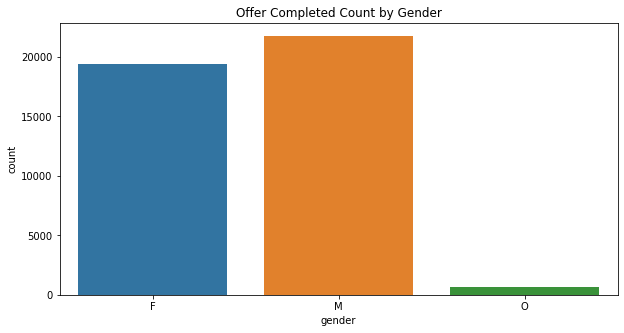

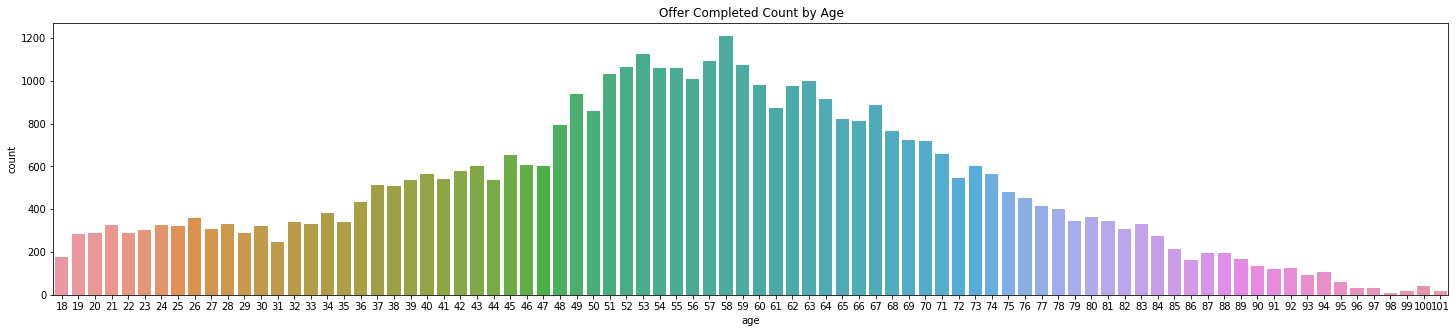

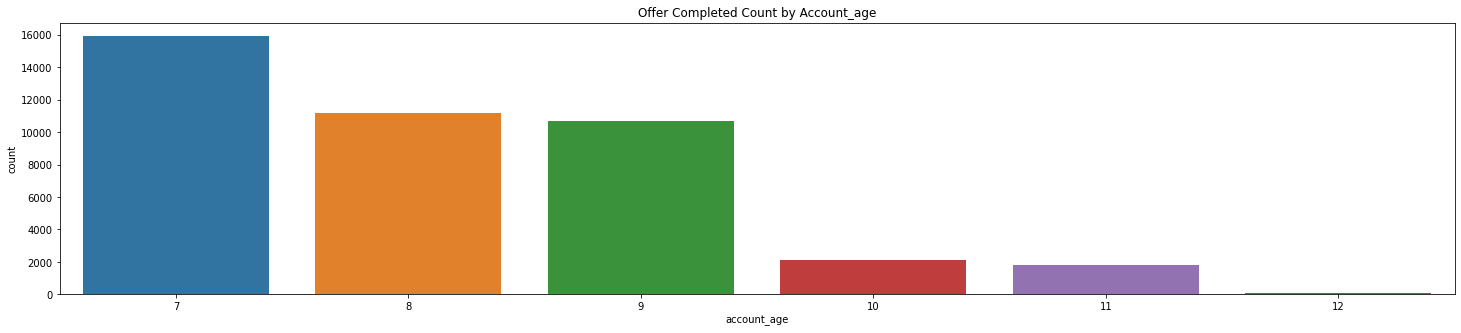

In [27]:
plot_offer_completed_count_by_column(offers_completed, "gender", figsize=(10,5))
plot_offer_completed_count_by_column(offers_completed, "age", figsize=(25,5))
plot_offer_completed_count_by_column(offers_completed, "account_age", figsize=(25,5))

Aqui fazemos um pré-processamento das ofertas recebidas x ofertas aceitas. 

Desse modo criamos 2 coluntas em que podemos agregar ambas as informações de cada transação por cliente de forma booleana, ficando mais facil a composição de features.

In [28]:
# filtering offers_received
offers_received = offers.filter(col("event") == "offer received").select("account_id",col("offer_id_from_struct").alias("offer_id"),
        "offer_type","event")

#mergin with offers completed
offers_received_completed_df = offers_received.join(
    offers_completed.select("account_id", 
                            "offer_id", 
                            col("offer_type").alias("offer_type_completed"), col("event").alias("completed")), on=["account_id", "offer_id"],
                            how="left"
).select("account_id", "offer_id", col("offer_type").alias("offer_type"), col("event").alias("received"), col("completed"))

users_with_offers = offers.filter(col("offer_id_from_struct").isNotNull()).select(
        "account_id",
        col("offer_id_from_struct").alias("offer_id"),
        "age",
        "gender",
        "registered_on",
        "account_age"
    )

user_offers = offers_received_completed_df.join(
    users_with_offers,
    on=["account_id", "offer_id"],
    how="left"
).dropDuplicates(["account_id", "offer_id", "offer_type", "received", "completed", "age", "gender", "registered_on", "account_age"])

#creating one hot column ffor offer_received and offer_completed
user_offers = user_offers.withColumn(
    "received",
    when(col("received") == "offer received", 1).otherwise(0)
).withColumn(
    "completed",
    when(col("completed") == "offer completed", 1).otherwise(0)
)

user_offers.limit(10).toPandas()

,account_id,offer_id,offer_type,received,completed,age,gender,registered_on,account_age
0,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,discount,1,1,33,M,20170421,8
1,003d66b6608740288d6cc97a6903f4f0,5a8bc65990b245e5a138643cd4eb9837,informational,1,1,26,F,20170621,8
2,004b041fbfe44859945daa2c7f79ee64,fafdcd668e3743c1bb461111dcafc2a4,discount,1,1,55,F,20180508,7
3,004c5799adbf42868b9cff0396190900,f19421c1d4aa40978ebb69ca19b0e20d,bogo,1,1,54,M,20160331,9
4,0056df74b63b4298809f0b375a304cf4,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,1,1,54,M,20160821,8
5,00715b6e55c3431cb56ff7307eb19675,ae264e3637204a6fb9bb56bc8210ddfd,bogo,1,1,58,F,20171207,7
6,0099bf30e4cb4265875266eb3eb25eab,fafdcd668e3743c1bb461111dcafc2a4,discount,1,1,61,M,20180214,7
7,00b3c376db2a4115af3aef34a02f61d6,ae264e3637204a6fb9bb56bc8210ddfd,bogo,1,1,50,M,20170627,8
8,00bc42a62f884b41a13cc595856cf7c3,fafdcd668e3743c1bb461111dcafc2a4,discount,1,1,44,M,20160111,9
9,00c20a9202d5475190b31a24de6fb06d,f19421c1d4aa40978ebb69ca19b0e20d,bogo,1,1,52,O,20160306,9


Realizando novamente o plot de ofertas completadas x apenas recebidas usando as novas colunas

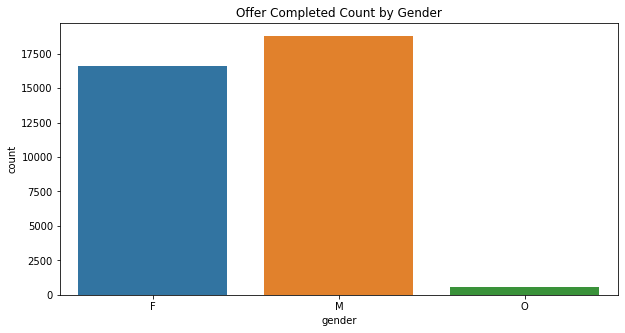

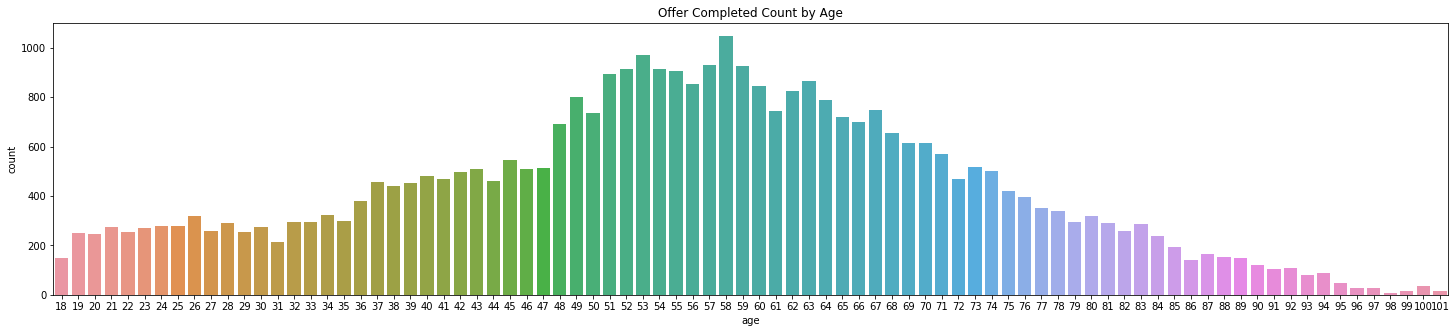

In [29]:
#Offers completed distribution(Genre and Age)

plot_offer_completed_count_by_column(user_offers.filter(col("completed") == 1), "gender", figsize=(10,5))
plot_offer_completed_count_by_column(user_offers.filter(col("completed") == 1), "age", figsize=(25,5))

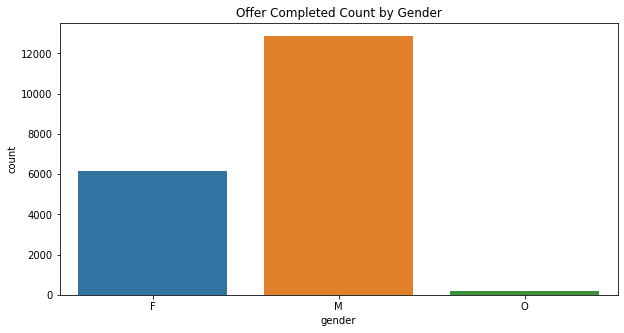

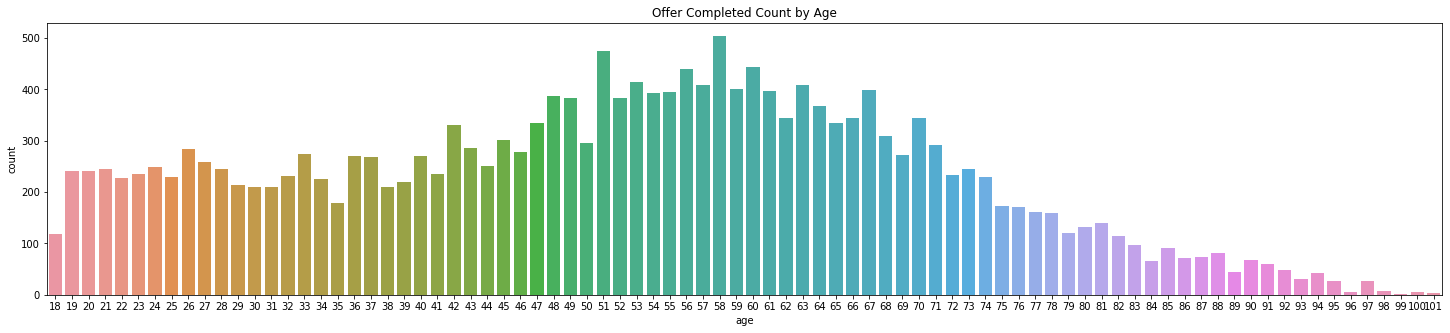

In [30]:
#Just received or viewed

plot_offer_completed_count_by_column(user_offers.filter(col("completed") == 0), "gender", figsize=(10,5))
plot_offer_completed_count_by_column(user_offers.filter(col("completed") == 0), "age", figsize=(25,5))

## Composição de features

Por fim aqui agrupamos os tipos de promoção para cada cliente baseado em seu histórico.

Dessa forma obtemos todas as estatisticas de transação, informações docliente como também o uso das promoções a fim de criar um modelo de previsão de envio de ofertas

In [50]:
from pyspark.sql.functions import collect_set, coalesce, lit, explode, max as _max
from pyspark.sql.types import ArrayType, StringType

# 1) Merge user_offers com stats_user_trans em account_id
users_offers_full = user_offers.join(stats_user_trans, on="account_id")
#users_offers_full.show()
# 2) Criar df_offer_usage: para accounts com completed=1, coletar conjunto de offer_type usados
df_offer_usage = users_offers_full.filter(col("completed") == 1).groupBy("account_id").agg(collect_set("offer_type").alias("offer_usage"))
df_offer_usage.show()
# 3) Merge df_offer_usage de volta em users_offers_full
# users_offers_full = users_offers_full.join(df_offer_usage, on="account_id", how="left")
# users_offers_full.show()
# 4) Tratar offer_usage nulo: substituir null por array vazio
#users_offers_full = users_offers_full.withColumn(
#    "offer_usage",
#    coalesce(col("offer_usage"), lit([]).cast(ArrayType(StringType())))
#)

# 5) Preencher valores nulos em gender com 'ND'
#users_offers_full = users_offers_full.fillna({"gender": "ND","amount_std": 0})

# 6) Preencher valores nulos em amount_std com 0


+--------------------+--------------------+
|          account_id|         offer_usage|
+--------------------+--------------------+
|0009655768c64bdeb...|[informational, d...|
|0011e0d4e6b944f99...|[informational, d...|
|0020c2b971eb4e918...|[informational, d...|
|0020ccbbb6d84e358...|[informational, d...|
|003d66b6608740288...|[informational, d...|
|00426fe3ffde4c6b9...|[informational, d...|
|004b041fbfe448599...|    [discount, bogo]|
|004c5799adbf42868...|    [discount, bogo]|
|005500a7188546ff8...|              [bogo]|
|0056df74b63b42988...|[informational, d...|
|00715b6e55c3431cb...|    [discount, bogo]|
|0082fd87c18f45f2b...|[informational, b...|
|00840a2ca5d2408e9...|    [discount, bogo]|
|008d7088107b46889...|     [informational]|
|0091d2b6a5ea4defa...|    [discount, bogo]|
|0099bf30e4cb42658...|          [discount]|
|00a794f62b9a48beb...|[informational, b...|
|00ae03011f9f49b8a...|[informational, d...|
|00b18b535d6d4f779...|[informational, d...|
|00b3400e4ff64ee68...|[informati

In [52]:
users_offers_full_pd = users_offers_full.toPandas()
df_offer_usage_pd = df_offer_usage.toPandas()

In [54]:
users_offer_final = users_offers_full_pd.merge(df_offer_usage_pd,on='account_id',how='left').fillna({"gender": "ND","amount_std": 0})
users_offer_final

,account_id,offer_id,offer_type,received,completed,age,gender,registered_on,account_age,amount_sum,amount_count,amount_mean,amount_std,offer_usage
0,0020ccbbb6d84e358d3414a3ff76cffd,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,1,1,24,F,20161111,8,154.050,12,12.837,4.284,"[informational, discount, bogo]"
1,0020ccbbb6d84e358d3414a3ff76cffd,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,1,1,24,F,20161111,8,154.050,12,12.837,4.284,"[informational, discount, bogo]"
2,0020ccbbb6d84e358d3414a3ff76cffd,5a8bc65990b245e5a138643cd4eb9837,informational,1,1,24,F,20161111,8,154.050,12,12.837,4.284,"[informational, discount, bogo]"
3,0020ccbbb6d84e358d3414a3ff76cffd,f19421c1d4aa40978ebb69ca19b0e20d,bogo,1,1,24,F,20161111,8,154.050,12,12.837,4.284,"[informational, discount, bogo]"
4,004b041fbfe44859945daa2c7f79ee64,fafdcd668e3743c1bb461111dcafc2a4,discount,1,1,55,F,20180508,7,138.360,6,23.060,3.410,"[discount, bogo]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53982,fff7576017104bcc8677a8d63322b5e1,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,1,1,71,M,20171031,7,29.940,6,4.990,2.027,"[discount, bogo]"
53983,fff7576017104bcc8677a8d63322b5e1,fafdcd668e3743c1bb461111dcafc2a4,discount,1,1,71,M,20171031,7,29.940,6,4.990,2.027,"[discount, bogo]"
53984,fffad4f4828548d1b5583907f2e9906b,5a8bc65990b245e5a138643cd4eb9837,informational,1,1,34,M,20170123,8,88.830,12,7.403,3.009,"[informational, bogo]"
53985,fffad4f4828548d1b5583907f2e9906b,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,1,1,34,M,20170123,8,88.830,12,7.403,3.009,"[informational, bogo]"


Por fim, para aproveitar a informação de uso de tipos de ofertas por cada cliente, vamos ver a distribuição dos tipos de oferta
Lojas de conveniência tem o maior número de operações fraudulentas, porém as compras pela Internet tem o maior valor desviado.


A média desviada também é maior em compras online.


A quantia média desviada dos top 10 estabelecimentos são bem próximas.


O maior total desviado foi encontrado no estabelecimento Kozey Boehm.

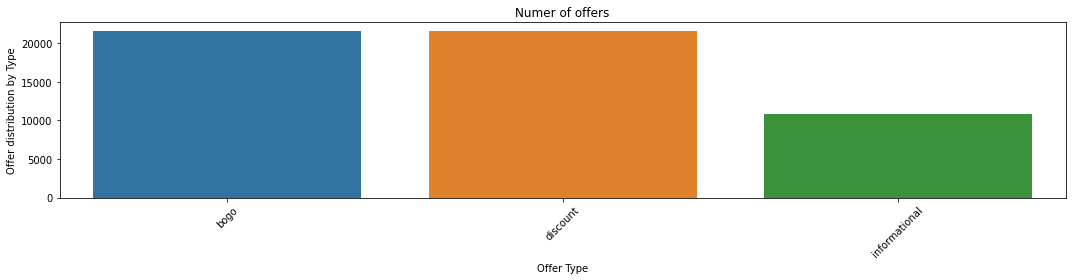

In [57]:
agg_df = users_offers_full.groupBy("offer_type").agg(_count("account_id").alias("count"))

# Converter para Pandas para usar seaborn
pd_df = agg_df.toPandas().sort_values("offer_type")

# Plot com seaborn
plt.figure(figsize=(15,4))
sns.barplot(data=pd_df, x="offer_type", y="count")
plt.xlabel("Offer Type")
plt.ylabel("Offer distribution by Type")
plt.title("Numer of offers")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [58]:
users_offer_final.to_parquet('user_offers_features.parquet')